Text(0.5, 1.0, 'RGB Image')

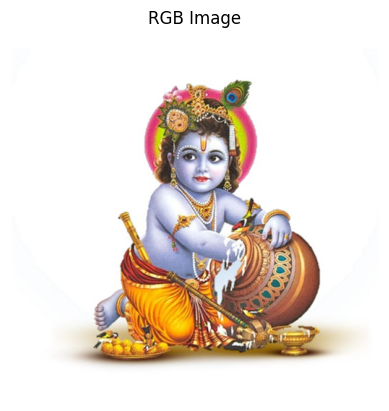

In [8]:
##part A
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

img = Image.open('/content/krishna.jpg').convert("RGB")
img = img.resize((512,512))
img_rgb = np.array(img)

plt.imshow(img_rgb)
plt.axis("off")
plt.title("RGB Image")


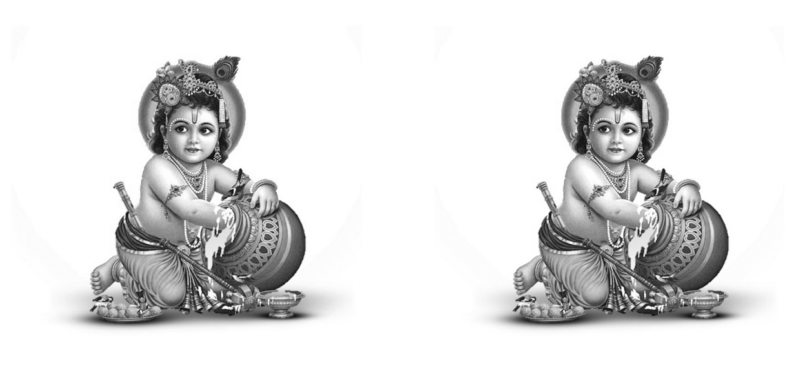

RGB: (512, 512, 3)
Gray: (512, 512)


In [9]:
rgb = img_rgb.astype(np.float32)

gray_manual = (0.299*rgb[:,:,0] + 0.587*rgb[:,:,1] + 0.114*rgb[:,:,2]).astype(np.uint8)
gray_cv2 = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_manual, cmap="gray")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(gray_cv2, cmap="gray")
plt.axis("off")
plt.show()

print("RGB:", img_rgb.shape)
print("Gray:", gray_manual.shape)


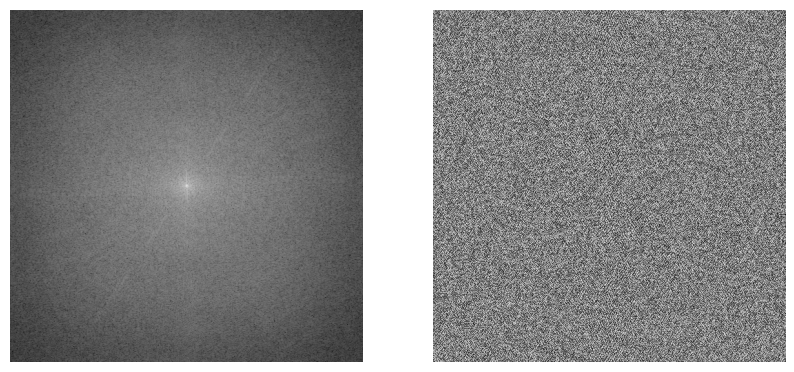

In [10]:
##part B
F = np.fft.fft2(gray_manual)
Fshift = np.fft.fftshift(F)

mag = np.abs(Fshift)
phase = np.angle(Fshift)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.log1p(mag), cmap="gray")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(phase, cmap="gray")
plt.axis("off")
plt.show()



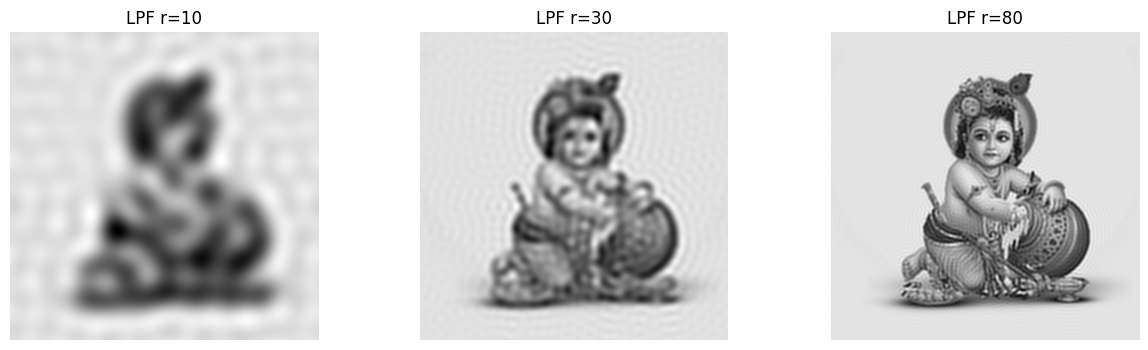

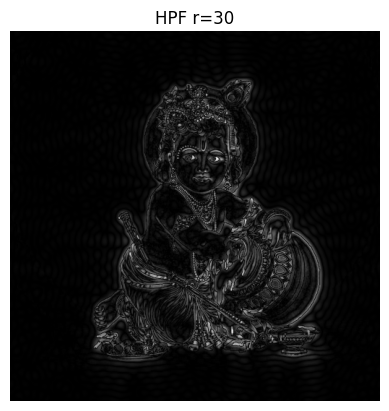

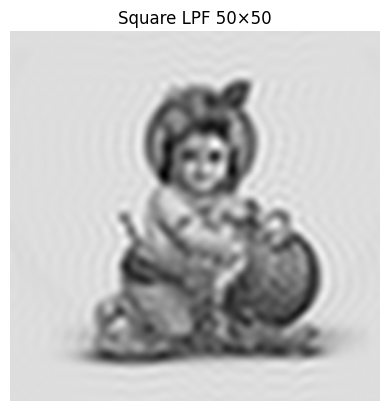

In [11]:
#part C
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, ifft2, ifftshift

H, W = gray_manual.shape

def lpf(r):
    Y, X = np.ogrid[:H, :W]
    return ((Y-H//2)**2 + (X-W//2)**2 <= r*r).astype(np.float32)

def hpf(r):
    return 1 - lpf(r)

def rec(mask):
    Fm = Fshift * mask
    out = np.abs(ifft2(ifftshift(Fm)))
    out = (255*(out - out.min())/(np.ptp(out) + 1e-9)).astype(np.uint8)   # FIXED
    return out

plt.figure(figsize=(15,4))
for i, r in enumerate([10,30,80]):
    plt.subplot(1,3,i+1)
    plt.imshow(rec(lpf(r)), cmap="gray")
    plt.title("LPF r="+str(r))
    plt.axis("off")
plt.show()

plt.imshow(rec(hpf(30)), cmap="gray")
plt.title("HPF r=30")
plt.axis("off")
plt.show()

sq = np.zeros((H,W))
s = 50
sq[H//2-s//2:H//2+s//2, W//2-s//2:W//2+s//2] = 1

plt.imshow(rec(sq), cmap="gray")
plt.title("Square LPF 50×50")
plt.axis("off")
plt.show()



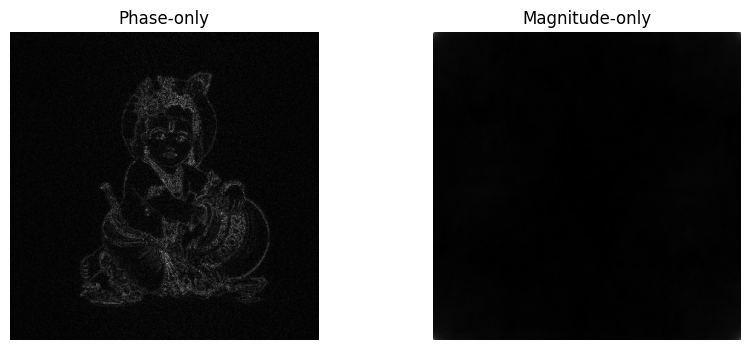

In [12]:
##part D

import numpy as np
from numpy.fft import ifft2, ifftshift, fftshift, fft2
import matplotlib.pyplot as plt

eps = 1e-9

# Phase-only
phase_only = Fshift / (np.abs(Fshift) + eps)
img_p = np.abs(ifft2(ifftshift(phase_only)))
img_p = (255 * (img_p - img_p.min()) / (np.ptp(img_p) + 1e-9)).astype(np.uint8)

# Magnitude-only (zero phase)
mag_only = np.abs(Fshift)
mag_spec = mag_only.astype(np.complex64)   # real-valued spectrum (phase=0)
img_m = np.abs(ifft2(ifftshift(mag_spec)))
img_m = (255 * (img_m - img_m.min()) / (np.ptp(img_m) + 1e-9)).astype(np.uint8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_p, cmap='gray')
plt.title('Phase-only')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_m, cmap='gray')
plt.title('Magnitude-only')
plt.axis('off')
plt.show()



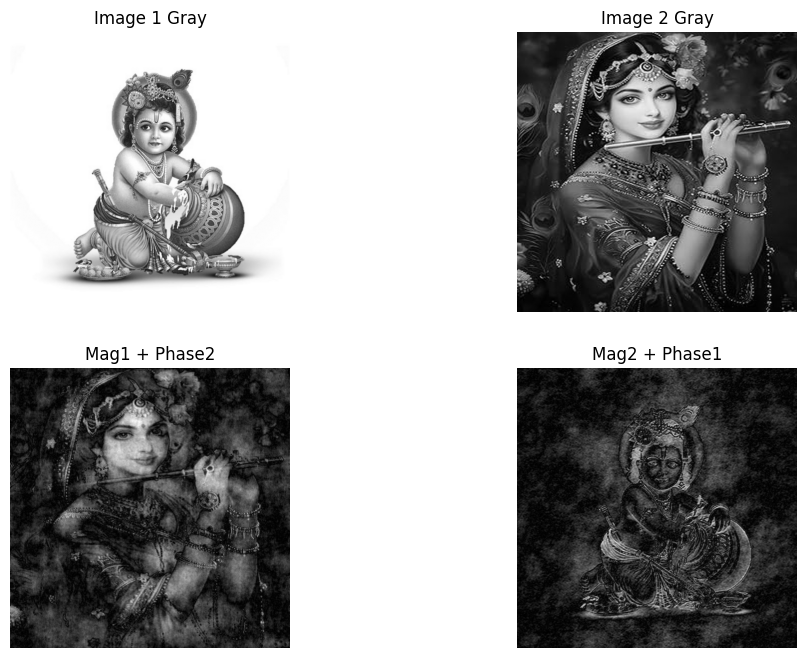

In [13]:
#part E

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from numpy.fft import fft2, fftshift, ifft2, ifftshift
import os

IMG1_PATH = "/content/krishna.jpg"
IMG2_PATH = "/content/radha.jpg"
SIZE = (512, 512)

def load_image(path, size):
    img = Image.open(path).convert("RGB")
    img = img.resize(size, Image.LANCZOS)
    return np.array(img)

# Load both images
assert os.path.exists(IMG1_PATH), f"Image not found: {IMG1_PATH}"
assert os.path.exists(IMG2_PATH), f"Image not found: {IMG2_PATH}"

img1 = load_image(IMG1_PATH, SIZE)
img2 = load_image(IMG2_PATH, SIZE)

# Convert to grayscale
g1 = (0.299*img1[:,:,0] + 0.587*img1[:,:,1] + 0.114*img1[:,:,2]).astype(np.float32)
g2 = (0.299*img2[:,:,0] + 0.587*img2[:,:,1] + 0.114*img2[:,:,2]).astype(np.float32)

# FFT
F1 = fftshift(fft2(g1))
F2 = fftshift(fft2(g2))

M1, P1 = np.abs(F1), np.angle(F1)
M2, P2 = np.abs(F2), np.angle(F2)

# Smooth magnitudes to reduce noise
M1s = cv2.GaussianBlur(M1, (0,0), sigmaX=3)
M2s = cv2.GaussianBlur(M2, (0,0), sigmaX=3)

# Normalize magnitudes
M1n = M1s / (np.max(M1s) + 1e-9)
M2n = M2s / (np.max(M2s) + 1e-9)

# Scaling
scale1 = np.mean(M1s)
scale2 = np.mean(M2s)

# Swap
C1 = (M1n * scale2) * np.exp(1j * P2)   # Mag1 + Phase2
C2 = (M2n * scale1) * np.exp(1j * P1)   # Mag2 + Phase1

# Reconstruct
R1 = np.abs(ifft2(ifftshift(C1)))
R2 = np.abs(ifft2(ifftshift(C2)))

def n255(x):
    return (255*(x - x.min()) / (np.ptp(x) + 1e-9)).astype(np.uint8)

R1n, R2n = n255(R1), n255(R2)
g1n, g2n = n255(g1), n255(g2)

# Display
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(g1n, cmap='gray')
plt.title("Image 1 Gray")
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(g2n, cmap='gray')
plt.title("Image 2 Gray")
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(R1n, cmap='gray')
plt.title("Mag1 + Phase2")
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(R2n, cmap='gray')
plt.title("Mag2 + Phase1")
plt.axis('off')
plt.show()

# Phase mainly controls the structure (shapes, boundaries, positions).
# Magnitude controls the texture, contrast, and overall energy of the image.

